In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

2.8.0
Num of GPUs available:  13


2022-04-09 07:40:37.965032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-09 07:40:37.965161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [5]:
# load training and testing sets
train_dataset_path = "../monkey/training/training/"
test_dataset_path = "../monkey/validation/validation/"
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train = datagen.flow_from_directory(train_dataset_path, target_size=(160, 160), batch_size=32)
test = datagen.flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=32, shuffle=False)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [6]:
# read labels
file = pd.read_csv('../monkey/monkey_labels.txt', sep='[\s,]{2,20}', engine='python')
labels = file['Common Name']
labels

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object

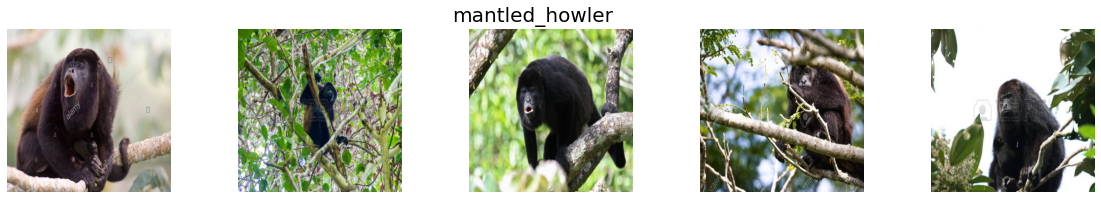

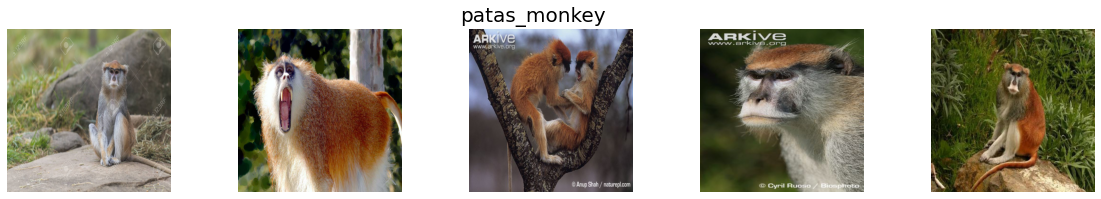

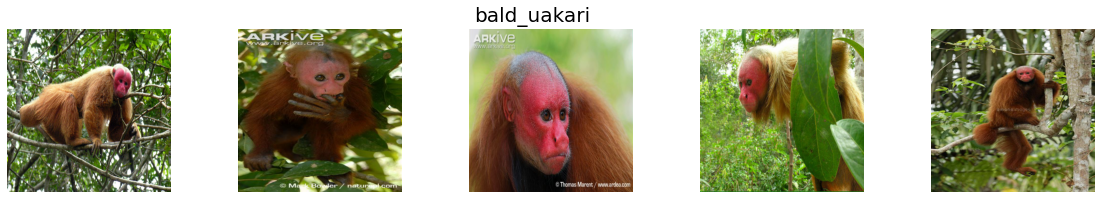

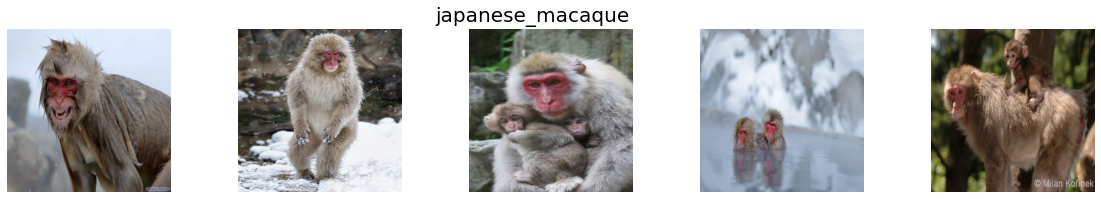

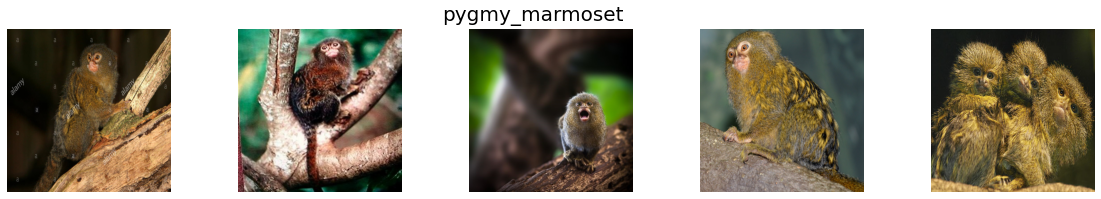

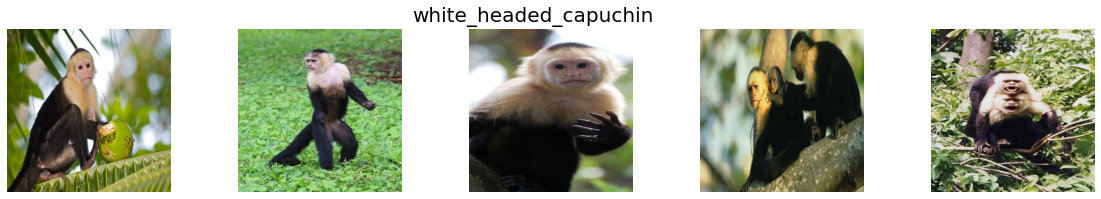

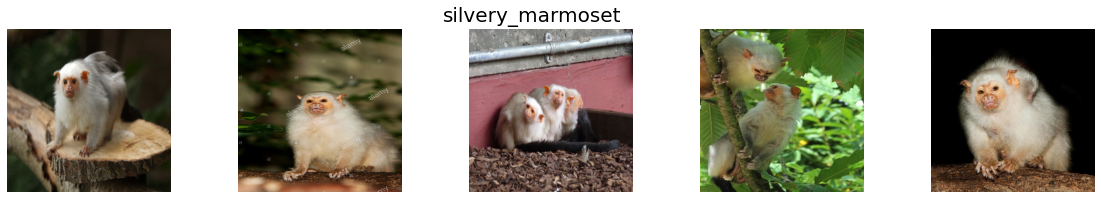

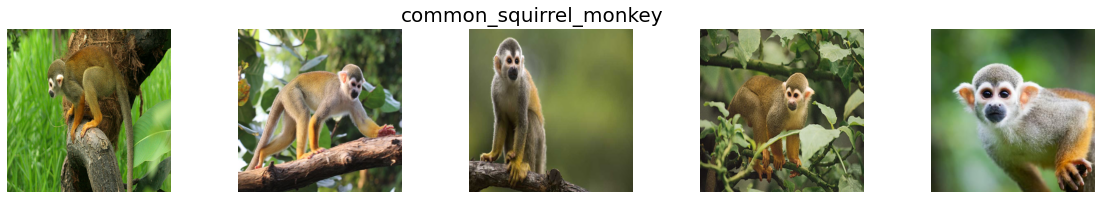

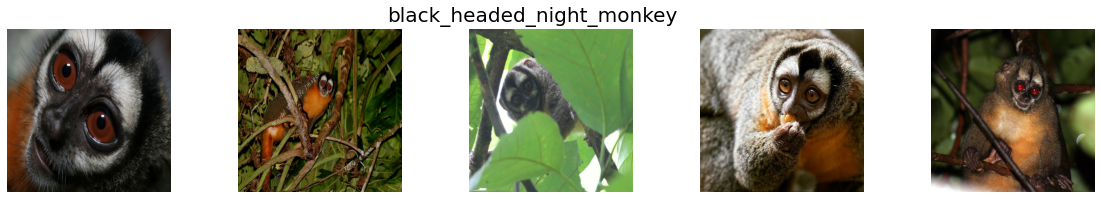

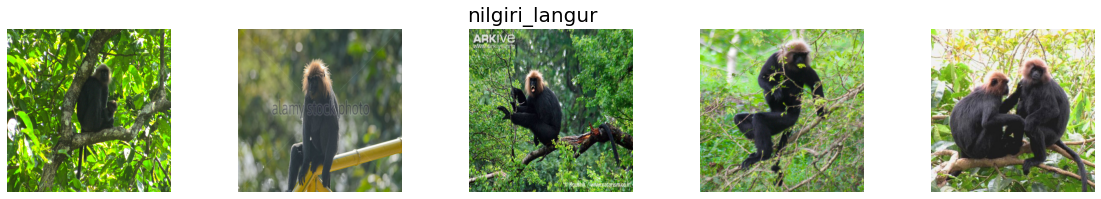

In [23]:
# display images of each category
folders = os.listdir(train_dataset_path)
folders.sort()
for i, folder in enumerate(folders):
    path = train_dataset_path + folder
    imgs = os.listdir(path)
    plt.figure(figsize=(20,3))
    for j in range(5):
        img = cv2.cvtColor(cv2.imread(path + '/' + imgs[j]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (640, 640))
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(labels[i], fontsize="20")
    plt.show()
    print("\n\n")

In [8]:
IMG_SHAPE = (160, 160, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

2022-04-09 07:40:43.856036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-09 07:40:43.856060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(514, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 514)               526850    
                                                             

In [10]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/ccao/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = model.fit(train, epochs=5)

Epoch 1/5
35/35 [==============================] - 12s 345ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 2/5
35/35 [==============================] - 12s 340ms/step - loss: 0.0151 - accuracy: 0.9982
Epoch 3/5
35/35 [==============================] - 12s 347ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 4/5
35/35 [==============================] - 12s 346ms/step - loss: 0.0095 - accuracy: 0.9991
Epoch 5/5
35/35 [==============================] - 13s 356ms/step - loss: 0.0073 - accuracy: 1.0000


{'loss': [0.018008125945925713, 0.015099391341209412, 0.010365836322307587, 0.009490543976426125, 0.007326521445065737], 'accuracy': [1.0, 0.9981784820556641, 1.0, 0.999089241027832, 1.0]}


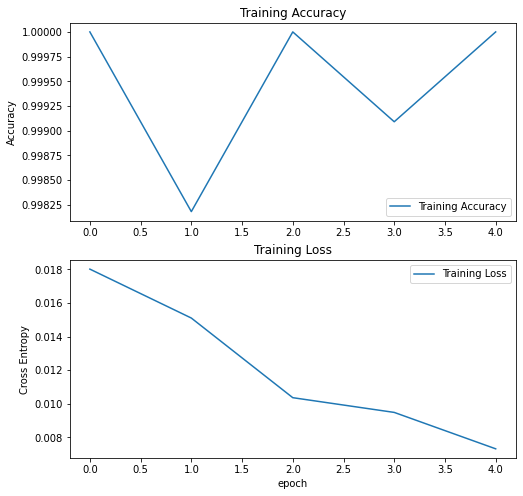

In [18]:
print( history.history)
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
prediction = model.predict_generator(test)
predicted_classes = np.argmax(prediction, axis=1)
test_acc = np.mean(predicted_classes == test.classes)
print("Test accuracy: {:.6f}".format(test_acc))

/var/folders/pc/fxtczc_j3_37b08vcjxv59p00000gn/T/ipykernel_67449/1852272414.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test)
2022-04-09 07:48:41.624909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 0.974265


In [20]:
show_test = ImageDataGenerator().flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=test.samples, shuffle=False)
x, _ = show_test.next()
classes = test.classes

Found 272 images belonging to 10 classes.


In [21]:
# generate random indices
random_indices = np.random.randint(0, test.samples, size=28)

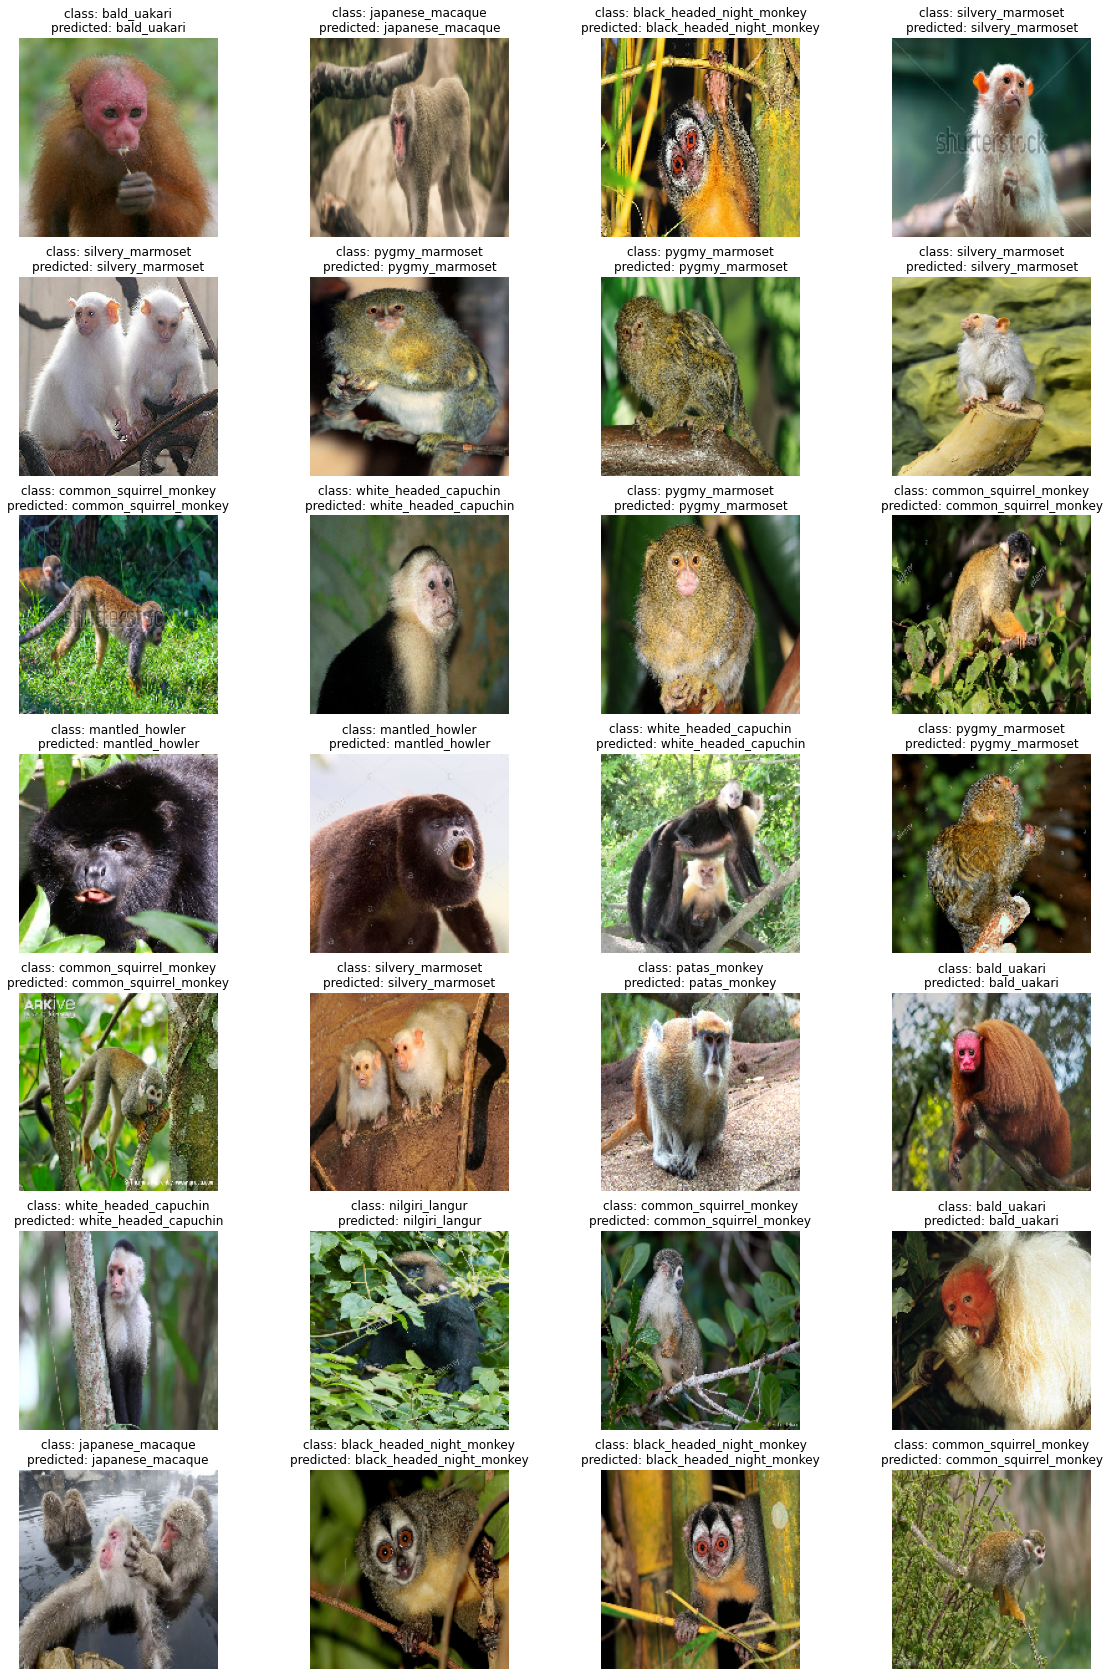

In [22]:
# prediction
plt.figure(figsize=(20,30))
for i, idx in enumerate(random_indices):
    img = np.uint8(x[idx])
    plt.subplot(7,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("class: " + labels[classes[idx]] + "\npredicted: " + labels[predicted_classes[idx]])
plt.show()